In [65]:
# import yfinance as yf
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error
# from pmdarima.arima import auto_arima
# from pylab import rcParams

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [117]:
# Define the ticker symbol
ticker_symbol = 'AAPL'  # Example: Apple Inc.

# Fetch historical stock price data using yfinance
stock_data = yf.download(ticker_symbol, start='2010-01-01', end='2023-12-31')

[*********************100%***********************]  1 of 1 completed


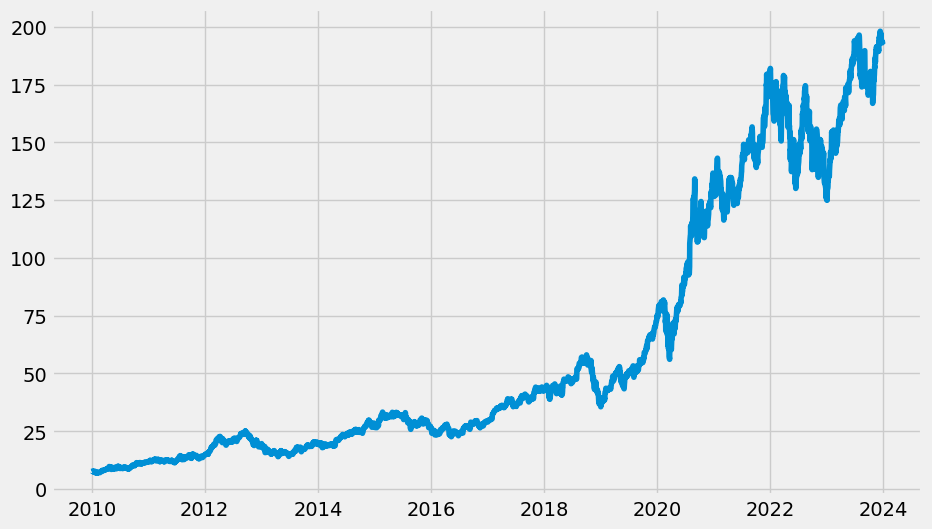

In [67]:
plt.plot(stock_data.Close)

In [68]:
data_training = pd.DataFrame(stock_data['Close'][0:int(len(stock_data)*0.70)])
data_testing = pd.DataFrame(stock_data['Close'][int(len(stock_data)*0.70):int(len(stock_data))])

print(data_training.shape)
print(data_testing.shape)

(2466, 1)
(1057, 1)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3344.028, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3345.928, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3345.917, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3346.726, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3348.024, Time=0.94 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.900 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2466
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1670.014
Date:                Sat, 20 Apr 2024   AIC                           3344.028
Time:                        17:12:44   BIC                           3355.647
Sample:                             0   HQIC                          3348.249
                               - 2466                                       

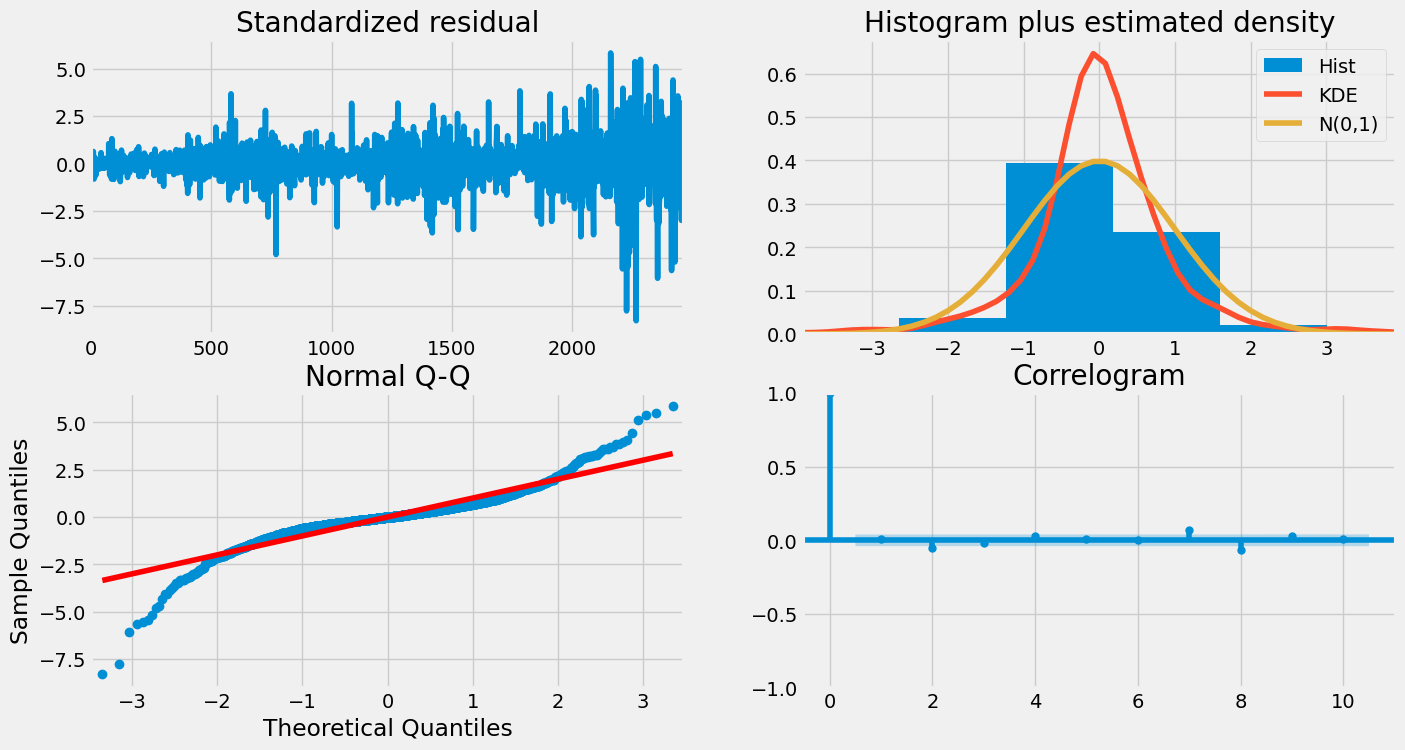

In [69]:
model_autoARIMA = auto_arima(data_training, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [102]:
#Modeling
# Build Model
# model = ARIMA(data_training, order=(1,1,2))  
# fitted = model.fit()  

model = sm.tsa.arima.ARIMA(data_training, order=(1,1,2))
result = model.fit()

print(result.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2466
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1669.278
Date:                Sat, 20 Apr 2024   AIC                           3346.557
Time:                        17:45:03   BIC                           3369.797
Sample:                             0   HQIC                          3355.000
                               - 2466                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1154      0.264      0.436      0.663      -0.403       0.634
ma.L1         -0.1074      0.266     -0.404      0.686      -0.628       0.413
ma.L2         -0.0483      0.014     -3.563      0.0

In [103]:
pred = result.forecast(1057, alpha=0.05)  # 95% conf

pred = pred.to_frame()

In [104]:
pred

,predicted_mean
2466,58.832985
2467,58.823506
2468,58.822412
2469,58.822286
2470,58.822271
...,...
3518,58.822270
3519,58.822270
3520,58.822270
3521,58.822270


In [107]:
data_testing['predicted_mean'] = pred['predicted_mean'].values

In [108]:
data_testing

,Close,predicted_mean
Date,,
2019-10-18,59.102501,58.832985
2019-10-21,60.127499,58.823506
2019-10-22,59.990002,58.822412
2019-10-23,60.794998,58.822286
2019-10-24,60.895000,58.822271
...,...,...
2023-12-22,193.600006,58.822270
2023-12-26,193.050003,58.822270
2023-12-27,193.149994,58.822270


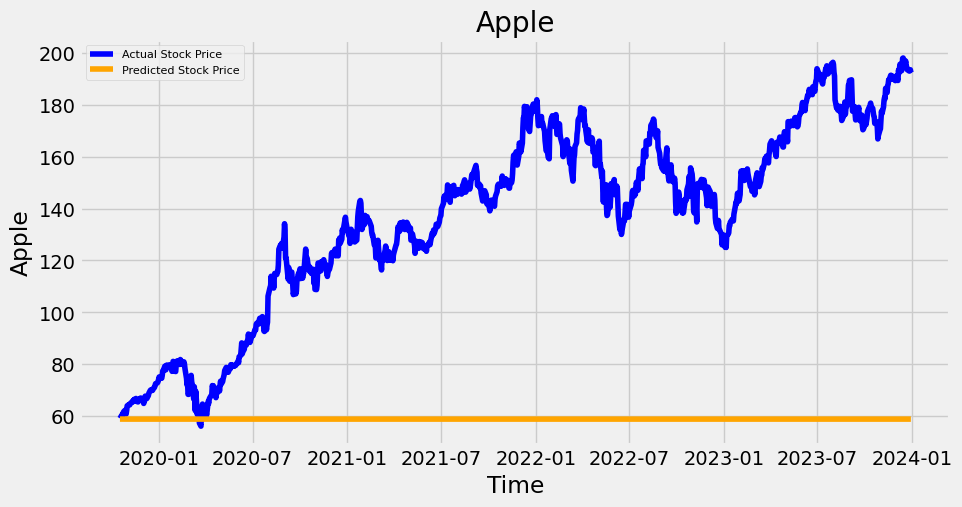

In [112]:
# Forecast
# fc = result.forecast(321, alpha=0.05)  # 95% conf
# fc, se, conf = result.forecast(321, alpha=0.05)  # 95% conf
# Make as pandas series
# fc_series = pd.Series(fc, index=data.index)
# lower_series = pd.Series(conf[:, 0], index=data_testing.index)
# upper_series = pd.Series(conf[:, 1], index=data_testing.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
# plt.plot(data_training, label='training data')
plt.plot(data_testing["Close"], color = 'blue', label='Actual Stock Price')
plt.plot(data_testing["predicted_mean"], color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Apple')
plt.xlabel('Time')
plt.ylabel('Apple')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [116]:
mae = np.mean(np.abs(data_testing["predicted_mean"] - data_testing["Close"]))

# Calculate the range of the target variable
target_range = np.max(data_testing["Close"]) - np.min(data_testing["Close"])

# Calculate the error percentage
error_percentage = (mae / target_range) * 100

print(f"Error Percentage: {error_percentage:.2f}%")

Error Percentage: 55.20%
